### 首先是vision_transformer的整体网络架构:

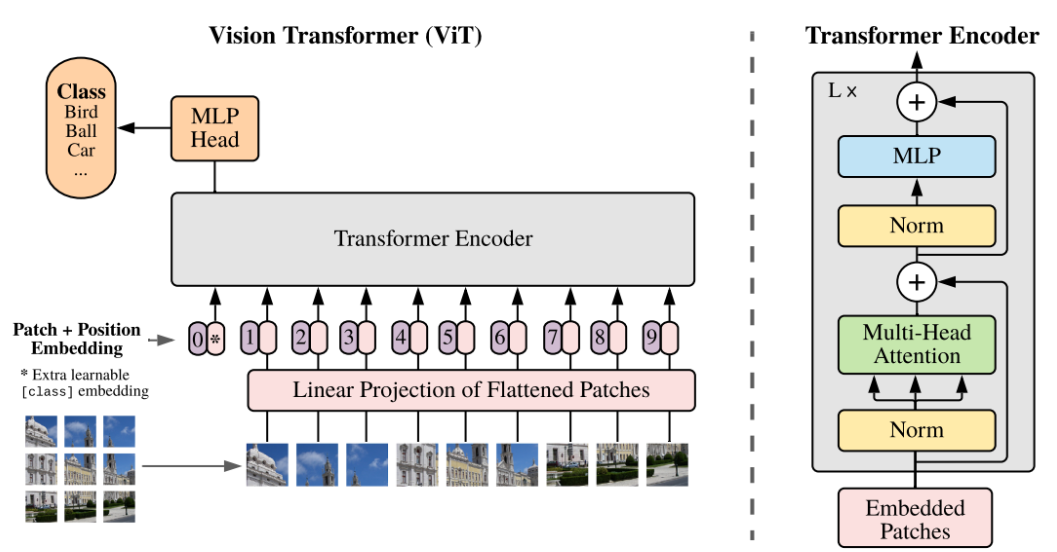

In [61]:

# 导入相应的库
import torch 
import torch.nn as nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [72]:
# helpers
def pairs(t):
    """
    将输入转换为元组形式。

    该函数接收一个输入 `t`，并检查其是否为元组。如果 `t` 已是元组，
    则直接返回 `t`；如果 `t` 不是元组，那么将 `t` 转换为一个包含两个元素的元组并返回。
    这在需要成对处理数据的场景中非常有用，例如在定义图形的宽高、坐标点等。

    参数:
    t: 输入值，可以是任何类型。

    返回:
    如果 `t` 是元组，则返回 `t`；否则，返回一个包含两个 `t` 的元组。
    """
    return t if isinstance(t, tuple) else (t, t)

In [73]:
# 定义前向反馈网络
class FeedForward(nn.Module):
    def __init__(self,dim,hidden_dim,dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),   # 这里表示在形状为dim的这一个维度进行层归一化
            nn.Linear(dim,hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim,dim),
            nn.Dropout(dropout)
        )
    def forward(self,x):
        return self.net(x)

In [75]:
# 定义注意力层
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head*heads # 也就是最后一个维度
        project_out = not (heads == 1 and dim_head == dim) # 判断是否要进行投影，也就是多头的时候要投影回dim维度

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)  # 在大小为dim的维度上进行归一化
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim*3, bias = False)  # 将dim维度映射到inner_dim*3维度
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim,dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self,x):
        # 此时接收的x的维度是(B,N,D)  N是指序列的长度，D是特征的维度
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3,dim = -1)  #chunk是在最后一个维度将张量分为三分，得到的qkv是一个包含3个张量的元组
        # map函数将qkv中的每个张量进行维度变换来更好进行乘法
        q, k , v = map(lambda t :rearrange(t, 'b n (h d) -> b h n d',h = self.heads),qkv) 
        dots = torch.matmul(q,k.transpose(-1,-2)*self.scale)  #transpose一下保证得到的输出是输入序列的相同长度

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out  = torch.matmul(attn,v)  #相乘之后得到的形状为(B,H,N,D)
        out = rearrange(out,'b h n d -> b n (h d)')  # H*D = dim
        return self.to_out(out)


In [76]:
# 定义transformer的encoder来实现图像的编码
class Transformer(nn.Module):
    def __init__(self,dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])  # 定义nn.ModuleList来存储多层结构
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim,heads = heads,dim_head=dim_head,dropout=dropout),
                FeedForward(dim,mlp_dim,dropout=dropout)
            ]))

    def forward(self,x):
        for attn,ff in self.layers:
            x = attn(x)+ x
            x = ff(x) + x
        return self.norm(x)   #对于最后一层的输出同样进行一次层归一化



In [77]:
class ViT(nn.Module):
    def __init__(self, *, image_size,patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls',
                 channels = 3, dim_head = 64, dropout = 0. ,emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pairs(image_size)
        patch_height, patch_width = pairs(patch_size)

        assert image_height % patch_height ==0 and image_width % patch_width == 0,'Image dimensions must be divisible by the patch size'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width  # 也就是分块之后的每一小块展开之后的维度
        assert pool in {'cls','mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)' 

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1,num_patches+1, dim))
        self.cls_token = nn.Parameter(torch.randn(1,1,dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim,depth=depth,heads=heads,dim_head=dim_head,mlp_dim=mlp_dim,dropout=dropout)

        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img): 
        x = self.to_patch_embedding(img)
        b,n,_ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d',b = b)
        x = torch.cat((cls_tokens,x),dim = 1)
        x += self.pos_embedding[:,:(n+1)]
        x = self.dropout(x)

        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:,0]

        x = self.to_latent(x)

        return self.mlp_head(x)
        

In [87]:
v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

img = torch.randn(1, 3, 256, 256)

preds = v(img) # (1, 1000)
values,indices = torch.max(preds,dim=1)
print(indices)
print(values)

tensor([319])
tensor([1.7086], grad_fn=<MaxBackward0>)
